In [1]:
# !git clone https://github.com/CompVis/latent-diffusion.git
# !git clone https://github.com/CompVis/taming-transformers
# !pip install -e ./taming-transformers
# !pip install ipywidgets omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

# import sys
# sys.path.append(".")
# sys.path.append('./taming-transformers')
# from taming.models import vqgan # checking correct import from taming

TODO:
1. 32-64, 64-256 接上
2. dataset 整理一下 （ffhq）
   1. load images in a for loop with downsample (bsr_sr downsample method)
3. get 32-256 models (AE, LDM) from server
4. scores

In [8]:
# %cd latent-diffusion
import ipywidgets as widgets
from IPython.display import display

mode = widgets.Select(options=['superresolution'],
    value='superresolution', description='Task:')
display(mode)

Select(description='Task:', options=('superresolution',), value='superresolution')

In [3]:
import torch
print(torch.__version__)

1.13.1+cu117


In [4]:
resolution = widgets.Select(options=['64-256', '32-64'],
    value='64-256', description='SR resolutions:')
display(resolution)

Select(description='SR resolutions:', options=('64-256', '32-64'), value='64-256')

In [5]:
# Define variables

## LDM 64->256
if resolution.value == "64-256":
    print("64-256 selected")
    path_conf = ".\\models\\trained_model_config\\ffhq256_sr.yaml"
    path_ckpt = ".\\trained_models\\epoch=000052_ldm64-256.ckpt"
    # path_ckpt = ".\\trained_models\\epoch=000049.ckpt"
    # path_conf = "./models/ldm/ffhq256/ffhq256_sr.yaml"
    # path_ckpt = "/home/zhren/Charlie/charlie-latent-diffusion/latent-diffusion/logs/2023-01-21T17-53-30_ffhq256_sr/checkpoints/epoch=000052.ckpt"
    # path_conf = ".\\models\\ldm\\bsr_sr\\config.yaml"
    # path_ckpt = ".\\models\\ldm\\bsr_sr\\model.ckpt"

    up_f = 4
## LDM 32->64
elif resolution.value == "32-64":
    print("32-64 selected")
    path_conf = ".\\models\\trained_model_config\\ffhq32-64_sr.yaml"
    path_ckpt = ".\\trained_models\\epoch=000028_ldm32-64.ckpt"
    up_f = 2
elif resolution.value == "32-256":
    print("32-256 selected")
    path_conf = ".\\models\\trained_model_config\\ffhq32-256_sr.yaml"
    path_ckpt = ".\\trained_models\\epoch=000053_ldm32-256.ckpt"
    up_f = 8
# path_conf = ".\\models\\ldm\\ffhq256\\ffhq256_sr.yaml"
# path_ckpt = ".\\trained_models\\epoch=000052.ckpt"

# path_conf = ".\\models\\ldm\\ffhq256\\ffhq32-64_sr.yaml"
# path_ckpt = ".\\trained_models\\epoch=000014.ckpt"
# uploaded_img = "" # 给一张照片

64-256 selected


In [6]:
import os
os.path.isfile(path_ckpt)
torch.cuda.is_available()
torch.cuda.empty_cache()


In [7]:
from notebook_helpers import get_local_model
model = get_local_model(path_conf, path_ckpt) # load model

Loading model from .\trained_models\epoch=000052.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from ./models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys


In [8]:
# from notebook_helpers import get_custom_cond

# get_custom_cond(mode.value, uploaded_img=uploaded_img)

In [9]:
from notebook_helpers import get_cond_options, get_cond
dir, options = get_cond_options(mode.value)
cond_choice = widgets.RadioButtons(
        options=options,
        description='Select conditioning:',
        disabled=False,
        value = "face64_1.png"
    )
display(cond_choice)

RadioButtons(description='Select conditioning:', index=5, options=('face256_1.png', 'face32_1.png', 'face32_2.…

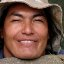

heyeheyhey
original c shape: torch.Size([1, 3, 64, 64])
heyeheyhey
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.53it/s]

Plotting: Restored training weights


In [10]:
from notebook_helpers import run
import os
custom_steps = 200
cond_choice_path = os.path.join(dir, cond_choice.value)
logs = run(model["model"], cond_choice_path, mode.value, custom_steps, up_f, downsample = False)

(1, 256, 256, 3)


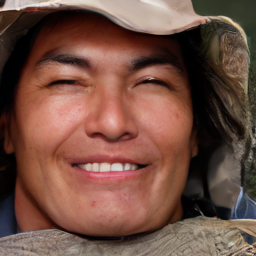

In [11]:
import torch
import numpy as np
import IPython.display as d
from PIL import Image

sample = logs["sample"]
sample = sample.detach().cpu()
sample = torch.clamp(sample, -1., 1.)
sample = (sample + 1.) / 2. * 255
sample = sample.numpy().astype(np.uint8)
sample = np.transpose(sample, (0, 2, 3, 1))
print(sample.shape)
a = Image.fromarray(sample[0])
display(a)


Connect 32-64, 64-256 cascaded model

# 32->256

In [14]:
from notebook_helpers import get_local_model

# path_conf = ".\\models\\trained_model_config\\ffhq32-64_sr.yaml"
# path_ckpt = ".\\trained_models\\epoch=000028_ldm-32-64.ckpt"
# model_lr = get_local_model(path_conf, path_ckpt) # load model
# up_f_lr = 2

# path_conf = ".\\models\\trained_model_config\\ffhq256_sr.yaml"
# path_ckpt = ".\\trained_models\\epoch=000052_ldm-64-256.ckpt"
# model_hr = get_local_model(path_conf, path_ckpt) # load model
# up_f_hr = 4

path_conf = ".\\models\\trained_model_config\\ffhq32-256_sr.yaml"
path_ckpt = ".\\trained_models\\epoch=000053_ldm-32-256.ckpt"
model_bl = get_local_model(path_conf, path_ckpt) # load model (bl:=baseline)
up_f_bl = 8

Loading model from .\trained_models\epoch=000053.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.63 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Restored from ./models/first_stage_models/vq-f8/model.ckpt with 0 missing and 49 unexpected keys


In [19]:
import ipywidgets as widgets
from IPython.display import display
from notebook_helpers import get_cond_options, get_cond
dir, options = get_cond_options("superresolution")
cond_choice = widgets.RadioButtons(
        options=options,
        description='Select conditioning:',
        disabled=False,
        value = "face64_1.png"
    )
display(cond_choice)

RadioButtons(description='Select conditioning:', index=5, options=('face256_1.png', 'face32_1.png', 'face32_2.…

In [20]:
cond_choice.value

'face64_1.png'

In [21]:
mode = widgets.Select(options=['superresolution'],
    value='superresolution', description='Task:')
display(mode)

Select(description='Task:', options=('superresolution',), value='superresolution')

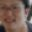

heyeheyhey
original c shape: torch.Size([1, 3, 32, 32])
heyeheyhey
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.36it/s]

Plotting: Restored training weights


In [17]:
from notebook_helpers import run
import os
custom_steps = 200
cond_choice_path = os.path.join(dir, cond_choice.value)
logs = run(model_bl["model"], cond_choice_path, mode.value, custom_steps, up_f_bl, downsample = False)

(1, 256, 256, 3)


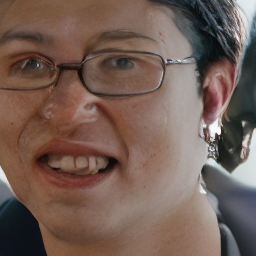

In [18]:
# 拿到了BL的结果，存起来
import torch
import numpy as np
import IPython.display as d
from PIL import Image
from datetime import datetime
def get_timestamp():
    return datetime.now().strftime('%y%m%d_%H%M%S')
sample = logs["sample"]
sample = sample.detach().cpu()
sample = torch.clamp(sample, -1., 1.)
sample = (sample + 1.) / 2. * 255
sample = sample.numpy().astype(np.uint8)
sample = np.transpose(sample, (0, 2, 3, 1))
print(sample.shape)
a = Image.fromarray(sample[0]) # it's now an image
a.save(".\\data\\generated_results\\BL32-256-2.png")
display(a)

In [11]:
from notebook_helpers import get_local_model

path_conf = ".\\models\\trained_model_config\\ffhq32-64_sr.yaml"
path_ckpt = ".\\trained_models\\epoch=000028_ldm-32-64.ckpt"
model_lr = get_local_model(path_conf, path_ckpt) # load model
up_f_lr = 2

path_conf = ".\\models\\trained_model_config\\ffhq256_sr.yaml"
path_ckpt = ".\\trained_models\\epoch=000052_ldm-64-256.ckpt"
model_hr = get_local_model(path_conf, path_ckpt) # load model
up_f_hr = 4

Loading model from .\trained_models\epoch=000028_ldm-32-64.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 256 in_channels
Working with z of shape (1, 3, 32, 32) = 3072 dimensions.
making attention of type 'vanilla' with 256 in_channels
Restored from ./trained_models/epoch=000168_ae-64-32.ckpt with 0 missing and 55 unexpected keys


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.42 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

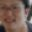

heyeheyhey
original c shape: torch.Size([1, 3, 32, 32])
heyeheyhey
torch.Size([1, 32, 32, 3]) torch.Size([1, 64, 64, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 26.67it/s]

Plotting: Restored training weights


In [6]:
from notebook_helpers import run
import os
custom_steps = 200
cond_choice_path = os.path.join(dir, cond_choice.value)
logs = run(model_lr["model"], cond_choice_path, mode.value, custom_steps, up_f_lr, downsample = False)

(1, 64, 64, 3)


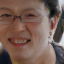

In [8]:
# 拿到了32-64的结果，存起来
import torch
import numpy as np
import IPython.display as d
from PIL import Image
from datetime import datetime
def get_timestamp():
    return datetime.now().strftime('%y%m%d_%H%M%S')
sample = logs["sample"]
sample = sample.detach().cpu()
sample = torch.clamp(sample, -1., 1.)
sample = (sample + 1.) / 2. * 255
sample = sample.numpy().astype(np.uint8)
sample = np.transpose(sample, (0, 2, 3, 1))
print(sample.shape)
a = Image.fromarray(sample[0]) # it's now an image
a.save(".\\data\\generated_results\\32-64-2.png")
display(a)

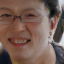

heyeheyhey
original c shape: torch.Size([1, 3, 64, 64])
heyeheyhey
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 18.84it/s]


Plotting: Restored training weights


In [9]:
custom_steps = 200
cond_choice_path = ".\\data\\generated_results\\32-64-2.png"
logs = run(model_hr["model"], cond_choice_path, mode.value, custom_steps, up_f_hr)

(1, 256, 256, 3)


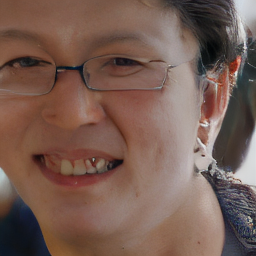

In [10]:
import torch
import numpy as np
import IPython.display as d
from PIL import Image
from datetime import datetime
def get_timestamp():
    return datetime.now().strftime('%y%m%d_%H%M%S')
sample = logs["sample"]
sample = sample.detach().cpu()
sample = torch.clamp(sample, -1., 1.)
sample = (sample + 1.) / 2. * 255
sample = sample.numpy().astype(np.uint8)
sample = np.transpose(sample, (0, 2, 3, 1))
print(sample.shape)
a = Image.fromarray(sample[0]) # it's now an image
a.save(".\\data\\generated_results\\64-256-1.png")
display(a)

# Measure metrics (SSIM PSNR)

In [1]:
# Read the image_path from folder
import os
ffhq_imgs = os.listdir(".\\data\\ffhq\\test_img\\")
print(ffhq_imgs)

['00100.png', '00101.png', '00102.png', '00103.png', '00104.png', '00105.png', '00106.png', '00107.png', '00108.png', '00109.png', '00110.png', '00111.png', '00112.png', '00113.png', '00114.png', '00115.png', '00116.png', '00117.png', '00118.png', '00119.png', '00120.png', '00121.png', '00122.png', '00123.png', '00124.png', '00125.png', '00126.png', '00127.png', '00128.png', '00129.png', '00130.png', '00131.png', '00132.png', '00133.png', '00134.png', '00135.png', '00136.png', '00137.png', '00138.png', '00139.png', '00140.png', '00141.png', '00142.png', '00143.png', '00144.png', '00145.png', '00146.png', '00147.png', '00148.png', '00149.png', '00150.png', '00151.png', '00152.png', '00153.png', '00154.png', '00155.png', '00156.png', '00157.png', '00158.png', '00159.png', '00160.png', '00161.png', '00162.png', '00163.png', '00164.png', '00165.png', '00166.png', '00167.png', '00168.png', '00169.png', '00170.png', '00171.png', '00172.png', '00173.png', '00174.png', '00175.png', '00176.png'

In [2]:
# baseline
from notebook_helpers import get_local_model
path_conf = ".\\models\\trained_model_config\\ffhq32-256_sr.yaml"
path_ckpt = ".\\trained_models\\epoch=000195_ldm-32-256.ckpt"
model_bl = get_local_model(path_conf, path_ckpt) # load model (bl:=baseline)
up_f_bl = 8

Loading model from .\trained_models\epoch=000195_ldm-32-256.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.63 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Restored from ./models/first_stage_models/vq-f8/model.ckpt with 0 missing and 49 unexpected keys


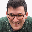

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.47it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


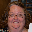

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.33it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


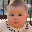

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


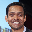

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.29it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


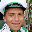

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.12it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


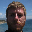

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.97it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


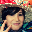

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 26.54it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


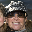

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 26.24it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


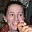

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


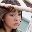

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.74it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


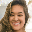

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.14it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


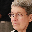

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.44it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


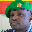

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 26.16it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


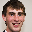

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.17it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


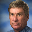

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 19.93it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


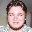

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.24it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


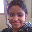

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.85it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


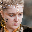

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.25it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


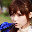

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


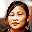

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.96it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


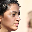

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.70it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


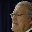

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.25it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


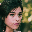

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.29it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


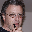

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.98it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


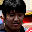

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 18.74it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


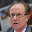

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.44it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


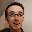

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.96it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


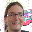

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.04it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


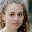

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.20it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


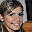

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.44it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


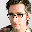

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 26.89it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


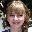

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.43it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


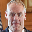

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.46it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


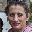

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.89it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


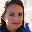

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.76it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


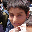

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 22.08it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


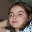

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.18it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


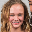

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.86it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


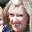

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:15<00:00, 13.29it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


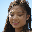

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.55it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


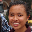

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.38it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


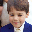

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.10it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


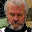

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.91it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


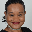

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.20it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


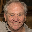

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.28it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


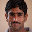

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.80it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


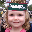

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.65it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


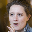

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.47it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


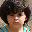

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 19.90it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


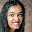

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.63it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


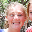

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.56it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


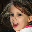

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.25it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


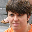

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.21it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


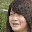

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.52it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


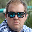

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.15it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


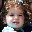

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.03it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


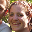

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.46it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


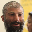

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.41it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


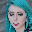

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.34it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


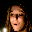

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.73it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


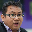

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.76it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


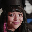

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.15it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


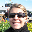

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.94it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


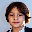

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.21it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


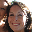

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.02it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


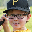

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 19.82it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


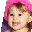

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.13it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


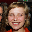

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.61it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


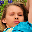

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.71it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


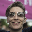

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.11it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


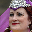

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.71it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


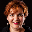

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.42it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


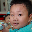

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.36it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


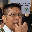

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 19.73it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


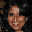

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.79it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


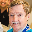

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.69it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


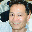

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.01it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


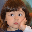

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.82it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


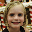

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 19.66it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


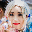

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 18.71it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


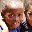

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.14it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


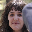

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.23it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


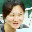

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.82it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


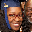

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.49it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


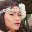

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 18.24it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


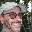

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.22it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


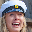

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.56it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


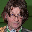

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.87it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


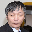

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.42it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


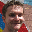

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.71it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


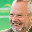

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.97it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


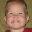

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:16<00:00, 12.28it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


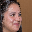

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.88it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


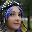

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 16.91it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


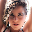

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.82it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


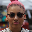

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.84it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


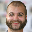

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 18.78it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


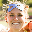

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 18.61it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


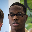

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 22.19it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


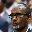

original c shape: torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 22.22it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


In [3]:
from notebook_helpers import run
import os
import torch
import numpy as np
import IPython.display as d
from PIL import Image
from datetime import datetime
def get_timestamp():
    return datetime.now().strftime('%y%m%d_%H%M%S')
custom_steps = 200
for idx, img in enumerate(ffhq_imgs):
    cond_choice_path = os.path.join(".\\data\\ffhq\\test_img\\", img)
    logs = run(model_bl["model"], cond_choice_path, "superresolution", custom_steps, up_f_bl, img_idx=idx)
    # 拿到了BL的结果，存起来
    sample = logs["sample"]
    sample = sample.detach().cpu()
    sample = torch.clamp(sample, -1., 1.)
    sample = (sample + 1.) / 2. * 255
    sample = sample.numpy().astype(np.uint8)
    sample = np.transpose(sample, (0, 2, 3, 1))
    print(sample.shape)
    a = Image.fromarray(sample[0]) # it's now an image
    a.save(f".\\data\\ffhq\\generated_img\\BL_epoch_195\\BL32-256-{idx}.png")

In [1]:
# First stage
from notebook_helpers import get_local_model

path_conf = ".\\models\\trained_model_config\\ffhq32-64_sr.yaml"
path_ckpt = ".\\trained_models\\epoch=000067_ldm-32-64.ckpt"
model_lr = get_local_model(path_conf, path_ckpt) # load model
up_f_lr = 2


Loading model from .\trained_models\epoch=000067_ldm-32-64.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 256 in_channels
Working with z of shape (1, 3, 32, 32) = 3072 dimensions.
making attention of type 'vanilla' with 256 in_channels
Restored from ./trained_models/epoch=000168_ae-64-32.ckpt with 0 missing and 55 unexpected keys


In [3]:
FS_dir = "FS_109"

In [ ]:
# 拿到了32-64的结果，存起来
from notebook_helpers import run
import os

import torch
import numpy as np
import IPython.display as d
from PIL import Image
FS_dir = "FS_109"
custom_steps = 200
for idx, img in enumerate(os.listdir(".\\data\\ffhq\\test_img\\")):
    cond_choice_path = os.path.join(".\\data\\ffhq\\test_img\\", img)
    logs = run(model_lr["model"], cond_choice_path, "superresolution", custom_steps, up_f_lr)
    sample = logs["sample"]
    sample = sample.detach().cpu()
    sample = torch.clamp(sample, -1., 1.)
    sample = (sample + 1.) / 2. * 255
    sample = sample.numpy().astype(np.uint8)
    sample = np.transpose(sample, (0, 2, 3, 1))
    print(sample.shape)
    a = Image.fromarray(sample[0]) # it's now an image
    a.save(f".\\data\\ffhq\\generated_img\\{FS_dir}\\FS32-64-{idx}.png")

In [1]:
from notebook_helpers import get_local_model

# Second Stage
path_conf = ".\\models\\trained_model_config\\ffhq256_sr.yaml"
path_ckpt = ".\\trained_models\\epoch=000052_ldm-64-256.ckpt"
model_hr = get_local_model(path_conf, path_ckpt) # load model
up_f_hr = 4

Loading model from .\trained_models\epoch=000052_ldm-64-256.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from ./models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys


.\data\ffhq\generated_img\FS_109\FS32-64-0.png


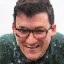

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:26<00:00,  7.45it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-1.png


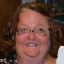

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-2.png


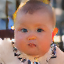

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:25<00:00,  7.85it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-3.png


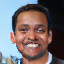

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:23<00:00,  8.63it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-4.png


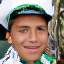

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:35<00:00,  5.59it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-5.png


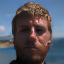

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:34<00:00,  5.85it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-6.png


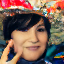

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:23<00:00,  8.40it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-7.png


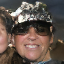

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:35<00:00,  5.69it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-8.png


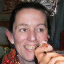

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:25<00:00,  7.86it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-9.png


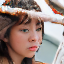

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:27<00:00,  7.32it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-10.png


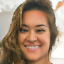

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-11.png


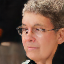

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:24<00:00,  8.22it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-12.png


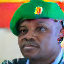

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:22<00:00,  8.83it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-13.png


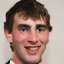

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:22<00:00,  8.72it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-14.png


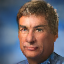

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:25<00:00,  7.94it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-15.png


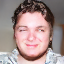

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:24<00:00,  8.33it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-16.png


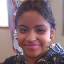

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:26<00:00,  7.46it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-17.png


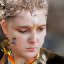

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:31<00:00,  6.44it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-18.png


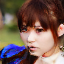

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:25<00:00,  7.80it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-19.png


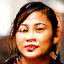

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.22it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-20.png


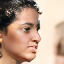

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.53it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-21.png


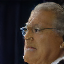

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.23it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-22.png


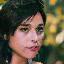

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:15<00:00, 12.77it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-23.png


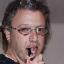

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.39it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-24.png


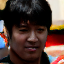

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 16.99it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-25.png


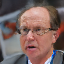

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.74it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-26.png


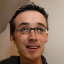

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.43it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-27.png


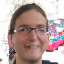

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 26.53it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-28.png


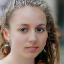

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:15<00:00, 12.67it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-29.png


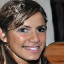

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:19<00:00, 10.23it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-30.png


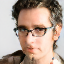

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:22<00:00,  9.07it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-31.png


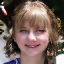

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.55it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-32.png


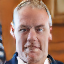

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.36it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-33.png


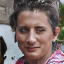

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.23it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-34.png


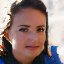

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.65it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-35.png


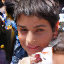

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.29it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-36.png


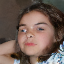

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.39it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-37.png


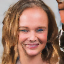

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.93it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-38.png


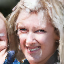

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.16it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-39.png


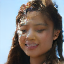

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.85it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-40.png


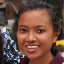

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.16it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-41.png


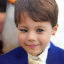

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.41it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-42.png


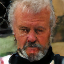

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 18.91it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-43.png


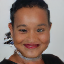

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.54it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-44.png


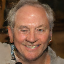

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.32it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-45.png


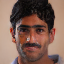

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.37it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-46.png


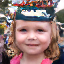

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.38it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-47.png


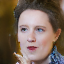

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.38it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-48.png


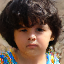

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.39it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-49.png


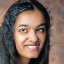

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-50.png


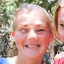

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 18.93it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-51.png


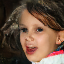

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.87it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-52.png


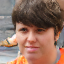

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 19.97it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-53.png


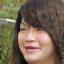

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.78it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-54.png


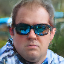

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.31it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-55.png


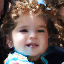

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.62it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-56.png


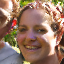

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.75it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-57.png


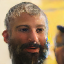

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 22.19it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-58.png


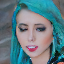

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.67it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-59.png


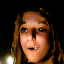

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 18.59it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-60.png


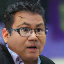

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.19it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-61.png


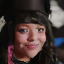

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.39it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-62.png


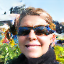

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.16it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-63.png


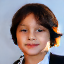

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.59it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-64.png


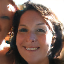

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.55it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-65.png


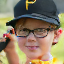

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.02it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-66.png


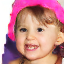

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.64it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-67.png


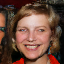

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 23.46it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-68.png


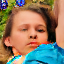

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.76it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-69.png


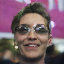

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.44it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-70.png


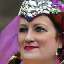

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:07<00:00, 25.90it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-71.png


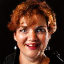

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.14it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-72.png


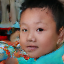

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:22<00:00,  9.05it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-73.png


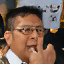

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:23<00:00,  8.40it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-74.png


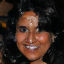

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:18<00:00, 10.87it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-75.png


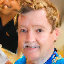

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:20<00:00,  9.78it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-76.png


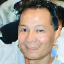

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:20<00:00,  9.76it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-77.png


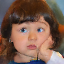

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:28<00:00,  6.91it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-78.png


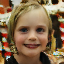

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:24<00:00,  8.18it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-79.png


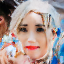

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:28<00:00,  6.98it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-80.png


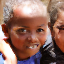

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:50<00:00,  3.97it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-81.png


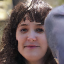

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:25<00:00,  7.91it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-82.png


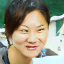

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 21.66it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-83.png


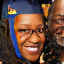

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 22.66it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-84.png


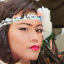

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.90it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-85.png


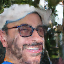

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 19.93it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-86.png


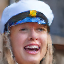

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.60it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-87.png


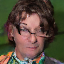

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.29it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-88.png


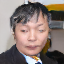

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.44it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-89.png


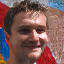

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-90.png


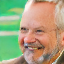

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.43it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-91.png


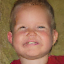

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 18.98it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-92.png


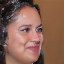

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.73it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-93.png


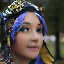

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 18.05it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-94.png


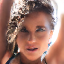

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.32it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-95.png


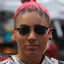

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:09<00:00, 20.27it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-96.png


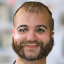

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.22it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-97.png


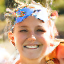

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.20it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-98.png


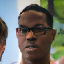

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 17.78it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\generated_img\FS_109\FS32-64-99.png


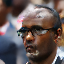

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 18.05it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


In [4]:
# 拿到了32-64的结果，存起来
from notebook_helpers import run
import os

import torch
import numpy as np
import IPython.display as d
from PIL import Image
def sort_by_number_ending(lst): # credit chatGPT
    return sorted(lst, key=lambda x: int(x[:-4].split("-")[-1]))
custom_steps = 200
# print(sort_by_number_ending(os.listdir(".\\data\\ffhq\\generated_img\\FS")))
for idx, img in enumerate(sort_by_number_ending(os.listdir(f".\\data\\ffhq\\generated_img\\{FS_dir}"))):
    cond_choice_path = os.path.join(f".\\data\\ffhq\\generated_img\\{FS_dir}", img)
    print(cond_choice_path)
    logs = run(model_hr["model"], cond_choice_path, "superresolution", custom_steps, up_f_hr, downsample = False)
    sample = logs["sample"]
    sample = sample.detach().cpu()
    sample = torch.clamp(sample, -1., 1.)
    sample = (sample + 1.) / 2. * 255
    sample = sample.numpy().astype(np.uint8)
    sample = np.transpose(sample, (0, 2, 3, 1))
    print(sample.shape)
    a = Image.fromarray(sample[0]) # it's now an image
    a.save(f".\\data\\ffhq\\generated_img\\SS_{FS_dir}\\SS64-256-{idx}.png")


In [4]:


# Example usage
lst = ['string-1', 'string-10', 'string-5']
print(sort_by_number_ending(lst))
# Output: ['string 1', 'string 5', 'string 10']

['string-1', 'string-5', 'string-10']


# More testing

In [1]:
from notebook_helpers import get_local_model

# Second Stage
path_conf = ".\\models\\trained_model_config\\ffhq256_sr.yaml"
path_ckpt = ".\\trained_models\\epoch=000052_ldm-64-256.ckpt"
model_hr = get_local_model(path_conf, path_ckpt) # load model
up_f_hr = 4

Loading model from .\trained_models\epoch=000052_ldm-64-256.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from ./models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys


.\data\ffhq\test_img\00100.png


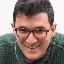

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.95it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00101.png


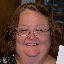

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:08<00:00, 24.70it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00102.png


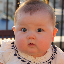

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 19.29it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00103.png


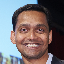

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.45it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00104.png


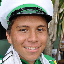

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:17<00:00, 11.72it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00105.png


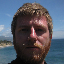

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:16<00:00, 12.06it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00106.png


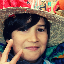

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:17<00:00, 11.13it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00107.png


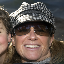

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:22<00:00,  8.90it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00108.png


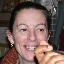

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:19<00:00, 10.28it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00109.png


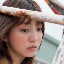

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:23<00:00,  8.46it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00110.png


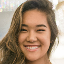

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:19<00:00, 10.17it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00111.png


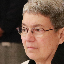

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:22<00:00,  8.94it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00112.png


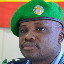

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:20<00:00,  9.91it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00113.png


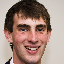

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00114.png


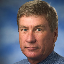

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:23<00:00,  8.46it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00115.png


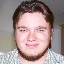

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:23<00:00,  8.36it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00116.png


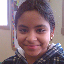

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:24<00:00,  8.17it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00117.png


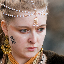

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:20<00:00,  9.71it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00118.png


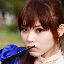

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:22<00:00,  8.91it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00119.png


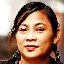

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:23<00:00,  8.37it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00120.png


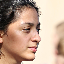

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:25<00:00,  7.93it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00121.png


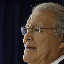

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:29<00:00,  6.89it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00122.png


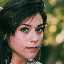

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:25<00:00,  7.69it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00123.png


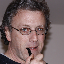

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:29<00:00,  6.77it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00124.png


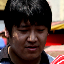

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:17<00:00, 11.17it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00125.png


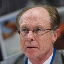

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:21<00:00,  9.28it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00126.png


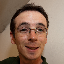

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:16<00:00, 12.25it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00127.png


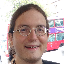

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.13it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00128.png


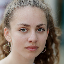

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.65it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00129.png


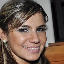

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.79it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00130.png


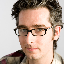

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.99it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00131.png


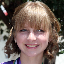

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.06it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00132.png


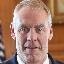

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.61it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00133.png


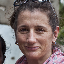

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.51it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00134.png


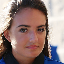

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:15<00:00, 13.09it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00135.png


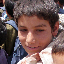

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:24<00:00,  8.29it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00136.png


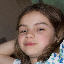

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:16<00:00, 12.25it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00137.png


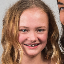

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.21it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00138.png


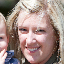

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:21<00:00,  9.39it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00139.png


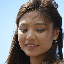

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00140.png


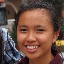

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:25<00:00,  7.79it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00141.png


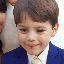

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:26<00:00,  7.61it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00142.png


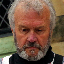

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:20<00:00,  9.95it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00143.png


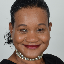

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00144.png


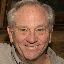

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.50it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00145.png


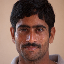

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.52it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00146.png


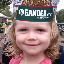

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.96it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00147.png


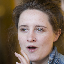

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.69it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00148.png


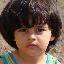

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.81it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00149.png


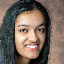

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.45it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00150.png


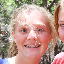

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.61it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00151.png


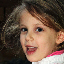

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.38it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00152.png


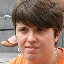

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.98it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00153.png


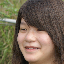

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.46it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00154.png


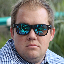

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.98it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00155.png


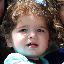

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.37it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00156.png


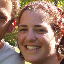

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.11it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00157.png


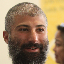

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.49it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00158.png


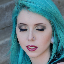

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.09it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00159.png


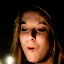

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.01it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00160.png


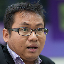

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:16<00:00, 11.99it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00161.png


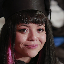

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:11<00:00, 16.72it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00162.png


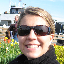

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.19it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00163.png


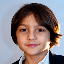

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 14.03it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00164.png


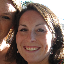

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.31it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00165.png


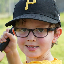

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.25it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00166.png


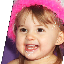

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.41it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00167.png


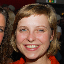

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.99it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00168.png


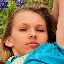

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.10it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00169.png


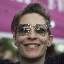

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.13it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00170.png


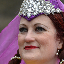

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.22it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00171.png


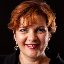

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.97it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00172.png


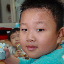

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.87it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00173.png


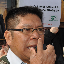

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.59it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00174.png


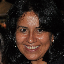

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.23it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00175.png


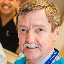

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 14.85it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00176.png


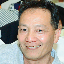

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.43it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00177.png


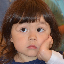

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 16.10it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00178.png


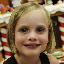

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.88it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00179.png


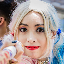

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.74it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00180.png


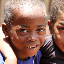

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.78it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00181.png


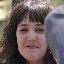

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:19<00:00, 10.34it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00182.png


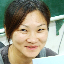

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:21<00:00,  9.21it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00183.png


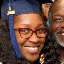

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:22<00:00,  8.87it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00184.png


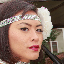

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.05it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00185.png


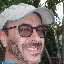

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:12<00:00, 15.47it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00186.png


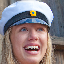

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.16it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00187.png


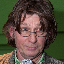

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.48it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00188.png


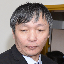

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:16<00:00, 12.42it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00189.png


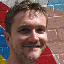

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:20<00:00,  9.93it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00190.png


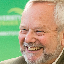

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.54it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00191.png


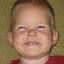

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00192.png


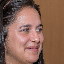

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:25<00:00,  7.88it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00193.png


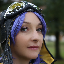

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:19<00:00, 10.28it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00194.png


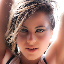

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:14<00:00, 13.42it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00195.png


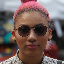

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:18<00:00, 10.94it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00196.png


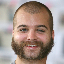

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:21<00:00,  9.33it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00197.png


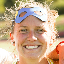

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:23<00:00,  8.58it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00198.png


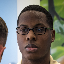

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:16<00:00, 11.80it/s]


Plotting: Restored training weights
(1, 256, 256, 3)
.\data\ffhq\test_img\00199.png


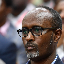

original c shape: torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 64, 3]) torch.Size([1, 256, 256, 3])
Plotting: Switched to EMA weights
Sampling with eta = 1.0; steps: 200
Data shape for DDIM sampling is (1, 3, 64, 64), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████| 200/200 [00:13<00:00, 15.33it/s]


Plotting: Restored training weights
(1, 256, 256, 3)


In [3]:
# 拿到了32-64的结果，存起来
from notebook_helpers import run
import os

import torch
import numpy as np
import IPython.display as d
from PIL import Image
def sort_by_number_ending(lst): # credit chatGPT
    return sorted(lst, key=lambda x: int(x[:-4].split("-")[-1]))
custom_steps = 200
# print(sort_by_number_ending(os.listdir(".\\data\\ffhq\\generated_img\\FS")))
for idx, img in enumerate(sort_by_number_ending(os.listdir(".\\data\\ffhq\\test_img\\"))):
    cond_choice_path = os.path.join(".\\data\\ffhq\\test_img\\", img)
    # cond_choice_path = os.path.join(".\\data\\ffhq\\generated_img\\FS", img)
    print(cond_choice_path)
    logs = run(model_hr["model"], cond_choice_path, "superresolution", custom_steps, up_f_hr, img_idx=idx)
    sample = logs["sample"]
    sample = sample.detach().cpu()
    sample = torch.clamp(sample, -1., 1.)
    sample = (sample + 1.) / 2. * 255
    sample = sample.numpy().astype(np.uint8)
    sample = np.transpose(sample, (0, 2, 3, 1))
    print(sample.shape)
    a = Image.fromarray(sample[0]) # it's now an image
    a.save(f".\\data\\ffhq\\generated_img\\SS_64\\SS64-256-{idx}.png")
